# Social Graphs & Interactions 2020 - Project B

## Introduction

For this's year project we have chosen to analyze the Viking Series dataset. As a little bit of history first, Vikings is a historical television drama series, that was first aired in Canada in 2013. Inspired by true events and characters, the shows tells the story of Ragnar Lothbrok, one of the best-known legendary Norse heroes and notorious as the scourge of England and France (source Wikipedia).

We decided to choose the Vikings show as our dataset for many reasons. First of all it's an award winning amazing show! Second of all, we are living in Denmark, the  country of origin of vikings. Third, the dataset itself provide plenty analysis opportunities, between all the show's elements. Last but not least, the game Assasins Creed: Valhalla just recently was launched so, if you are a gamer the vikings topic is more relevant than ever ;).

The ambition of this notebook and site, is to give a basic but clear analysis on the viking's tv show's elements to someone who is not an expert in network analysis or python.


## Basic stats. Let's understand the dataset better

We used the Fandom Wiki page for downloading the relevant data. This is the link: https://vikings.fandom.com/wiki/Category:Characters. We also used Fandom APIs guide in order to extract the show's element pages. https://www.wikia.com/api/v1/#!/Articles/getAsSimpleJson_get_0. Besides the main dataset, data regarding each's season ratings (https://www.rottentomatoes.com/tv/vikings_2013) and each season's viewrship were gathered from the internet (https://tvseriesfinale.com/tv-show/vikings-season-two-27736/) and the dataset Views.xlsx was constructed in order to gain further insights.

For starters we are extracting all show's elements (characters, seasons and episodes) and we are storing them in a list. Then we proceed to cleaning. More specifically we are dealing with the non ascii characters by converting them to ascii as well as with the show's characters without a wiki page. How do we know which characters are leading to a blank page? Well, we printed every page content and once the code crushed, we removed the relevant character from the list, after we doublecheck that it was indeed leading to a blank page. For the non ascii characters, the function isascii() was used at first, and then, the functions urllib.parse.urlsplit to split the URL into its components, urllib.parse.quote to properly quote/escape the unicode characters and urllib.parse.urlunsplit to join the URL back together. (source: https://stackoverflow.com/questions/4389572/how-to-fetch-a-non-ascii-url-with-python-urlopen)

 Use urllib.parse.urlsplit to split the URL into its components, and urllib.parse.quote to properly quote/escape the unicode characters and urllib.parse.urlunsplit to join it back together.

Once the text was extracted, it was stored in a separate .txt file. All in all, we got 610 main files. At first we generated 598 files, but during the process we created some more for storing the main and recurring cast of each season and the deaths. Total data size: 3,5 MB.

For every season, two separate files were created, one that contains the season's character's and the other one that contains the season's deaths. They are called "Season X Cast.txt" and "Season X Deaths.txt". (X = number of season).

last but not least, we have created a bar chart, displaying the flunctuation of deaths for every season. What is it impressive indeed is that during the last season noone died and this is not something that someone would have expected when it comes to a historical drama show.

In [1]:
import pandas as pd
import requests
import urllib.request
import urllib
import json
import io
import re
import os
from urllib.request import urlopen                                                                                                                                                            
from urllib.parse import quote
%matplotlib inline
import networkx as nx
import glob
from matplotlib import pyplot


#get all show's elements
base = "https://vikings.wikia.com/api/v1/Articles/List?Category:Characters&"
limit ="limit=614"
query = "%s%s"%(base,limit)
textloadlist = json.loads(urllib.request.urlopen(query).read())
characters = urllib.request.urlopen(query).read()
namelist = []

for i in range(len(textloadlist["items"])):
    namelist.append(textloadlist["items"][i]["title"])

In [3]:
#remove characters without a wiki page
#deal with non ascii characters
for i in range(len(namelist)):
    if namelist[i] == "Princess Kwenthrith":
        namelist.remove("Princess Kwenthrith")
    if namelist[i] == "Ragnarok":
        namelist.remove("Ragnarok")
    if namelist[i] == "Ragnarök\ufeff":
        namelist.remove("Ragnarök\ufeff")
    if namelist[i] == "Raid on Hexham":
        namelist.remove("Raid on Hexham")
    if namelist[i] == "Raid on Lindisfarne":
        namelist.remove("Raid on Lindisfarne") 
    if namelist[i] == "764":
        namelist.remove("764")
    if namelist[i] == "Athelstan/Gallery":
        namelist.remove("Athelstan/Gallery")
    if namelist[i] == "FamilyTree/End":
        namelist.remove("FamilyTree/End")
    if namelist[i] == "FamilyTree/Start":
        namelist.remove("FamilyTree/Start")
    if namelist[i] == "FamilyTree/Step2":
        namelist.remove("FamilyTree/Step2")
    if namelist[i] == "Gunnhild (wife of Horik)":
        namelist.remove("Gunnhild (wife of Horik)")
    check_ascii = namelist[i].isascii() 
    if check_ascii == False:
        url = urllib.parse.urlsplit(namelist[i])
        url = list(url)
        url[2] = urllib.parse.quote(url[2])
        namelist[i] = urllib.parse.urlunsplit(url)

In [4]:
for i in range(len(namelist)):
    base1 = "https://vikings.wikia.com/api.php?"
    base2 = "action=query&titles=%s" %namelist[i]
    base2 = base2.replace(" ","_")
    base3 = "&prop=revisions&rvprop=content&format=json"
    query = "%s%s%s" %(base1, base2, base3)
    response = urllib.request.urlopen(query)
    source = response.read()
    jsondata = json.loads(source)['query']['pages']
    page=next(iter(jsondata.values()))
    text=page['revisions'][0]['*']
    filename = "%s.txt" %namelist[i]
    f = io.open(filename, "w+", encoding = "utf-8")
    f.write(text)
    f.close
    folder = "characters/%s" %filename
    os.rename(filename, folder)
print("done") #message

done


In [5]:
#find total number of files
filelist = glob.glob('characters/*')
l = len(filelist)
print("Total number of files:", l) 

Total number of files: 598


In [18]:
seasons = ['Season 1', 'Season 2', 'Season 3', 'Season 4', 'Season 5', 'Season 6']

for i in range(0,len(seasons)):
    
    recording = False
    your_file = "characters/%s.txt" %seasons[i]
    #print(your_file)
    start_pattern = "== Season Deaths =="
    stop_pattern = "==Trivia=="
    output_section = []
    for line in open(your_file).readlines():
        if recording is False:
            if re.search(start_pattern, line) is not None:
                recording = True
                output_section.append(line.strip())
        elif recording is True:
            if re.search(stop_pattern, line) is not None:
                recording = False
            output_section.append(line.strip())
    #print('\n'.join(output_section))
    filename = "%s Deaths.txt" %seasons[i]
    f = io.open(filename, "w+", encoding = "utf-8")
    f.write('\n'.join(output_section))
    f.close
    folder = "characters/%s" %filename
    os.rename(filename, folder)

In [21]:
deaths = [] #empty list, will later store the total number of deaths per season
for i in range(0,len(seasons)):    
    mylines = []
    file = "characters/%s Deaths.txt" %seasons[i]
    with open (file, 'rt') as myfile: 
        for myline in myfile:
            if myline!= '\n':
                mylines.append(myline)
                #print(myline)
        if (len(mylines)!=0):
            deaths.append(len(mylines)-2) # every file has a header "== Season Deaths== and a las line call "== Trivia=="
        else:                             # we need to remove these two lines in order to get the total amount of deaths per season
            deaths.append(len(mylines)) # season 6 has 0 deaths so it doesn't make sense to substract 2

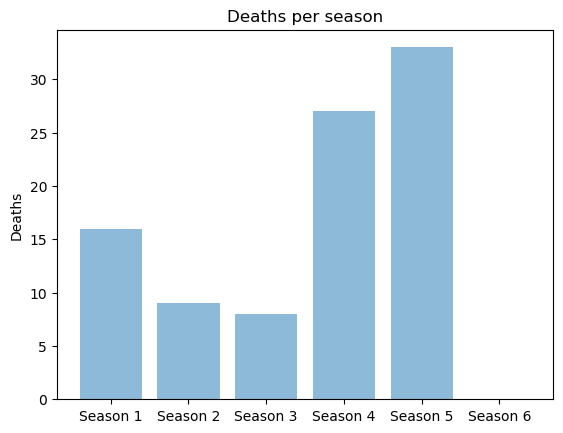

In [23]:
#total deaths per season bar chart

import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np

objects = ('Season 1', 'Season 2', 'Season 3', 'Season 4', 'Season 5', 'Season 6')
y_pos = np.arange(len(deaths))

plt.bar(y_pos, deaths, align='center', alpha=0.5)
plt.xticks(y_pos, objects)
plt.ylabel('Deaths')
plt.title('Deaths per season')

plt.show()

In [25]:
views = pd.read_excel('Views.xlsx')

## Tools, theory and analysis. Describe the process of theory to insight

Now it's time to generate the undirected graph with the Graph function from the network package. Firstly, we create an empty graph and then we add the nodes accordingly. Every node has different color depending on the element's status: if it is still alive in the show then the node is green, if it's not alive then the node is red and if the life status it's not applicable (if we are talking about an episode or a season) then the node is grey. Once all the nodes have been added to the graph, we proceed with the edges. In order to add an edge between two nodes, we check whether the first string can be found into the file of the second one. In the end an undirected graph is generated, with 10700 edges and 603 nodes.

Using the degree() funtion we can find which nodes have the highest degree and we choose to display the top-15 of them. Out of the most common centrality measures (Degree of centrality, Closeness centrality, Betweenness centrality), degree centrality is chosen because it's the most suitable one in order to identify the most connected nodes (source: https://cambridge-intelligence.com/keylines-faqs-social-network-analysis/). The result is sorted and only the top-10 is being displayed.

In [6]:
#generate the graph

G=nx.Graph()
#G.add_nodes_from(namelist)
color_map = []

#attributes based on element's status
stringtocheck_1 = "status = Alive"
stringtocheck_2 = "status = Deceased"

for i in range(len(namelist)):
    filename = "characters/%s.txt" %namelist[i].replace("_"," ")
    f=io.open(filename, "r", encoding='utf-8')
    readfile = f.read()
    match_1 = re.search(stringtocheck_1, readfile) #search for the status value in the file
    match_2 = re.search(stringtocheck_2, readfile)
    if match_1!=None:
        G.add_node(namelist[i], status = 'Alive')
        #the node is green if the show element is alive
        color_map.append('#32CD32')
    elif match_2!=None:
        G.add_node(namelist[i], status = 'Deceased')
        #the node is red if the show element is dead
        color_map.append('#FF0000')
    else:
        G.add_node(namelist[i], status = 'NA')
        #the node is grey if the attribute status is not applicable for this specific element
        color_map.append('#808080')  
        
for i in range(len(namelist)):
    name=namelist[i].replace("_"," ")
    for j in range(len(namelist)):
        #namelist[j] = namelist[j].replace("_"," ")
        if j==i:
            continue  
        filename = "characters/%s.txt" %namelist[j].replace("_"," ")
        f=io.open(filename, "r", encoding='utf-8')
        readfile = f.read()
        match = re.search(name, readfile)
        if match!=None:
            G.add_edge(namelist[j], namelist[i])

The number of edges =  10700
The number of nodes =  603


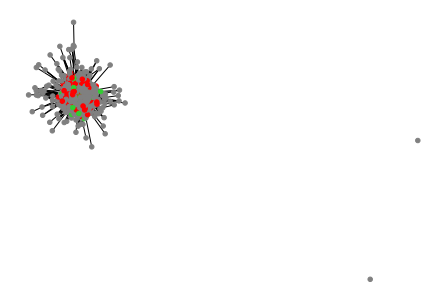

In [7]:
nx.draw(G, node_color = color_map, node_size=20)
print("The number of edges = ", G.number_of_edges())
print("The number of nodes = ", G.number_of_nodes())

In [8]:
#degree of nodes
D = sorted(G.degree(), key=lambda x: x[1], reverse=True) 

print("These are the top 15 elements of the show with the highest degree")
for i in range(0,15):
    print(D[i])

These are the top 15 elements of the show with the highest degree
('Viking', 435)
('Vik', 420)
('Vikings', 381)
('Ragnar', 285)
('Bjorn', 232)
('Kattegat', 225)
('Lagertha', 220)
('Harald', 201)
('Ivar', 191)
('Ubbe', 179)
('Rollo', 172)
('Floki', 171)
('Season 5', 168)
('Hvitserk', 167)
('Earl', 165)


In [14]:
# https://medium.com/towards-artificial-intelligence/social-network-analysis-of-game-of-thrones-in-networkx-ff21ef65dc11
# degree centrality of the graph G
deg_cen = nx.degree_centrality(G)
# Compute the page rank of G: page_rank
#page_rank = nx.pagerank(G)
sorted(deg_cen.items(), key=lambda x:x[1], reverse=True)[0:10]

[('Viking', 0.7225913621262459),
 ('Vik', 0.6976744186046512),
 ('Vikings', 0.632890365448505),
 ('Ragnar', 0.473421926910299),
 ('Bjorn', 0.3853820598006645),
 ('Kattegat', 0.37375415282392027),
 ('Lagertha', 0.3654485049833887),
 ('Harald', 0.3338870431893688),
 ('Ivar', 0.31727574750830567),
 ('Ubbe', 0.2973421926910299)]

In [17]:
clique = nx.find_cliques(G) 
# get the largest clique 
largest_clique = sorted(clique, key=lambda x:len(x))[-1]
print(largest_clique)

['Viking', 'Vik', 'Vikings', 'Ragnar', 'Bjorn', 'Lagertha', 'Kattegat', 'Floki', 'Rollo', 'Aslaug', 'Ubbe', 'Hvitserk', 'Helga', 'Wessex', 'Torvi', 'Season 4', 'Harald', 'What Might Have Been', 'Promised']


In [24]:
#create separate files with each seasons cast

for i in range(0,len(seasons)):
    
    recording = False
    your_file = "characters/%s.txt" %seasons[i]
    #print(your_file)
    start_pattern = "== Cast =="
    stop_pattern = "== Crew =="
    output_section = []
    for line in open(your_file).readlines():
        if recording is False:
            if re.search(start_pattern, line) is not None:
                recording = True
                output_section.append(line.strip())
        elif recording is True:
            if re.search(stop_pattern, line) is not None:
                recording = False
            output_section.append(line.strip())
    #print('\n'.join(output_section))
    filename = "%s Cast.txt" %seasons[i]
    f = io.open(filename, "w+", encoding = "utf-8")
    f.write('\n'.join(output_section))
    f.close
    folder = "characters/%s" %filename
    os.rename(filename, folder)

cast = []
for i in range(0,len(seasons)):    
    mylines = []
    file = "characters/%s Deaths.txt" %seasons[i]
    with open (file, 'rt') as myfile: 
        for myline in myfile:
            if myline!= '\n':
                mylines.append(myline)
                #print(myline)
        if (len(mylines)!=0):
            cast.append(len(mylines))
        else:
            cast.append(len(mylines))

As explained before, we constructed a dataset that contains each season's rating's and average viewership's. We present the view rating's in the graph below. What is interesting it that there is a clear downturn in the show's views, season after season. Usually that happens, when the leading character has left the show. Thus, in our case it would be interesting to see whether the life status of the 3  most significant characters, has impacted the show's view's numbers.

Text(0.5, 1.0, 'Average Viewership per season')

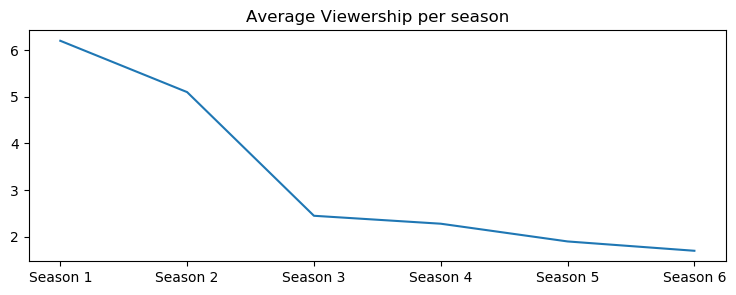

In [26]:
views['Viewership'].plot(figsize=(9, 3))
plt.xticks(y_pos, objects)
plt.ylabel('')
plt.title('Average Viewership per season')

In [27]:
#see whether the death some of the main protagonists had an impact on the show's ratings.
#Ragnar Bjorn Lagertha

characters = ['Ragnar', 'Bjorn', 'Lagertha']
for j in range(0,len(characters)):
    for i in range(len(seasons)):
        filename ="characters/%s Deaths.txt" %seasons[i]
        with open (filename, 'rt') as myfile:
            for myline in myfile:
                myline = myline.replace("[["," ")
                myline = myline.replace("]]"," ")
                myline = myline.replace("*"," ")
                if characters[j] in myline:
                    character_d = seasons[i] 
                    print('Character ' + characters[j] + ' dies at ' + seasons[i])

Character Ragnar dies at Season 4


In [28]:
print(character_d)

Season 4


As we can see, only Ragnar has died, during season 4. The graph below illustrates the moment of death in relation with season's views. As we can see, very slightly, between season 3 and 4, the view numbers were low but almost stable while after Ragnar's death, these numbers have been reducted more.

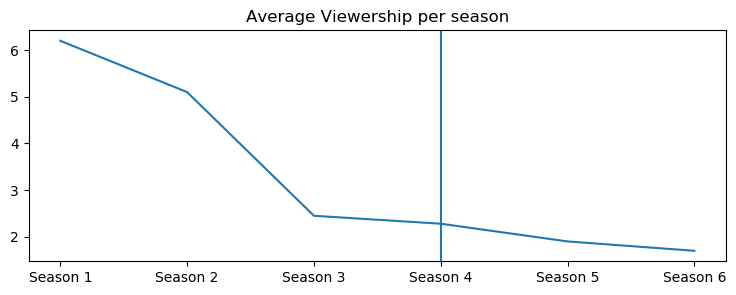

In [29]:
views['Viewership'].plot(figsize=(9, 3))
plt.xticks(y_pos, objects)
plt.ylabel('')
plt.title('Average Viewership per season')

xcoords = [3]

plt.axvline(xcoords)
plt.show()

Next, it would be interesting to explore each season's critic' reviews, in terms with the respective views. The main question is: do low ratings equals to bad critic's reviews?

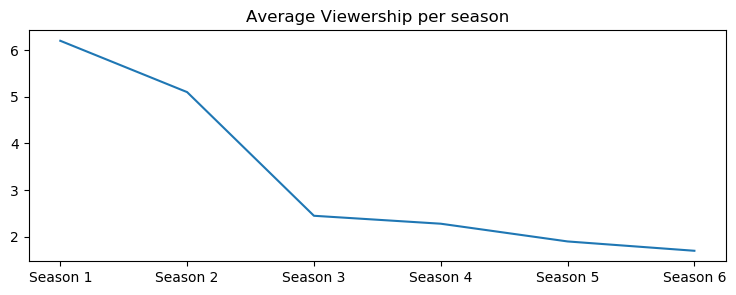

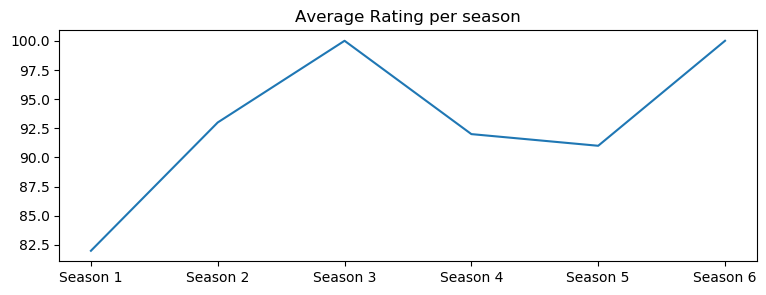

In [30]:
views['Viewership'].plot(figsize=(9, 3))
plt.xticks(y_pos, objects)
plt.ylabel('')
plt.title('Average Viewership per season')
plt.show()

views['Ratings'].plot(figsize=(9, 3))
plt.xticks(y_pos, objects)
plt.ylabel('')
plt.title('Average Rating per season')
plt.show()

As we can clearly see from the graphs presented above, the answer to the previous stated question is no. For instace, looking at season 3, it's the season with maybe the highest review rating but pretty low viewership number. The same stands for season 6 as well. On the contrary, season 1 has the highest number of views but the lowest number in terms of reviews.

## Discussion

Overall the project went well, but I think it does mostly the "basics". Given the dataset and how rich and multidimensional it it as well as the amount of analysis opportunities that is offers, more could be done. For instance, 6 different graphs could be generated, one for evey season and then the character developent could be evaluated. Also some predictive models (such as simple linear regression) could be applied in order to predict the status of each character (dead, alive or n/a)

## Individual Contributions

I conducted the project by myself so everything was done by me :). Whenever I used articles from the internet, I have inserted the relevant links.